# COVID-19 Makalelerini Analiz Etme

Bu görevde, COVID pandemisi konusuna devam edeceğiz ve bu konudaki bilimsel makalelerin işlenmesine odaklanacağız. [CORD-19 Veri Seti](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge), (bu yazının yazıldığı sırada) COVID hakkında 7000'den fazla makale içermektedir ve bu makaleler meta veriler ve özetlerle birlikte sunulmaktadır (ve bunların yaklaşık yarısı için tam metin de sağlanmıştır).

Bu veri setinin [Text Analytics for Health](https://docs.microsoft.com/azure/cognitive-services/text-analytics/how-tos/text-analytics-for-health/?WT.mc_id=academic-77958-bethanycheum) bilişsel hizmeti kullanılarak analiz edilmesine dair tam bir örnek [bu blog yazısında](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) açıklanmıştır. Biz bu analizin basitleştirilmiş bir versiyonunu tartışacağız.


In [145]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Verilerin Alınması

Öncelikle, üzerinde çalışacağımız CORD makalelerinin meta verilerini almamız gerekiyor.

**NOT**: Bu depo kapsamında veri kümesinin bir kopyasını sağlamıyoruz. Öncelikle [`metadata.csv`](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge?select=metadata.csv) dosyasını [Kaggle'daki bu veri kümesinden](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge) indirmeniz gerekebilir. Kaggle'a kayıt olmanız gerekebilir. Ayrıca, veri kümesini kayıt olmadan [buradan](https://ai2-semanticscholar-cord-19.s3-us-west-2.amazonaws.com/historical_releases.html) indirebilirsiniz, ancak bu durumda meta veri dosyasına ek olarak tüm tam metinleri de içerecektir.

Veriyi doğrudan çevrimiçi kaynaktan almaya çalışacağız, ancak bu başarısız olursa, yukarıda açıklandığı gibi veriyi indirmeniz gerekecek. Ayrıca, veriyi daha fazla denemek istiyorsanız indirmeniz mantıklı olacaktır, böylece bekleme süresinden tasarruf edebilirsiniz.

> **NOT**: Veri kümesi oldukça büyük, yaklaşık 1 GB boyutunda ve aşağıdaki kod satırının tamamlanması uzun sürebilir! (~5 dakika)


In [146]:
df = pd.read_csv("https://datascience4beginners.blob.core.windows.net/cord/metadata.csv.zip",compression='zip')
# df = pd.read_csv("metadata.csv")
df.head()

C:\winapp\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning:

Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.



cord_uid                                       sha source_x  \
0  ug7v899j  d1aafb70c066a2068b02786f8929fd9c900897fb      PMC   
1  02tnwd4m  6b0567729c2143a66d737eb0a2f63f2dce2e5a7d      PMC   
2  ejv2xln0  06ced00a5fc04215949aa72528f2eeaae1d58927      PMC   
3  2b73a28n  348055649b6b8cf2b9a376498df9bf41f7123605      PMC   
4  9785vg6d  5f48792a5fa08bed9f56016f4981ae2ca6031b32      PMC   

                                               title                    doi  \
0  Clinical features of culture-proven Mycoplasma...  10.1186/1471-2334-1-6   
1  Nitric oxide: a pro-inflammatory mediator in l...           10.1186/rr14   
2    Surfactant protein-D and pulmonary host defense           10.1186/rr19   
3               Role of endothelin-1 in lung disease           10.1186/rr44   
4  Gene expression in epithelial cells in respons...           10.1186/rr61   

      pmcid pubmed_id license  \
0  PMC35282  11472636   no-cc   
1  PMC59543  11667967   no-cc   
2  PMC59549  11667972   no-cc   
3  PMC59574  11686871   no-cc   
4  PMC59580  11686888   no-cc   

                                            abstract publish_time  \
0  OBJECTIVE: This retrospective chart review des...   2001-07-04   
1  Inflammatory diseases of the respiratory tract...   2000-08-15   
2  Surfactant protein-D (SP-D) participates in th...   2000-08-25   
3  Endothelin-1 (ET-1) is a 21 amino acid peptide...   2001-02-22   
4  Respiratory syncytial virus (RSV) and pneumoni...   2001-05-11   

                                             authors         journal  mag_id  \
0                Madani, Tariq A; Al-Ghamdi, Aisha A  BMC Infect Dis     NaN   
1  Vliet, Albert van der; Eiserich, Jason P; Cros...      Respir Res     NaN   
2                                    Crouch, Erika C      Respir Res     NaN   
3  Fagan, Karen A; McMurtry, Ivan F; Rodman, David M      Respir Res     NaN   
4  Domachowske, Joseph B; Bonville, Cynthia A; Ro...      Respir Res     NaN   

  who_covidence_id arxiv_id  \
0              NaN      NaN   
1              NaN      NaN   
2              NaN      NaN   
3              NaN      NaN   
4              NaN      NaN   

                                      pdf_json_files  \
0  document_parses/pdf_json/d1aafb70c066a2068b027...   
1  document_parses/pdf_json/6b0567729c2143a66d737...   
2  document_parses/pdf_json/06ced00a5fc04215949aa...   
3  document_parses/pdf_json/348055649b6b8cf2b9a37...   
4  document_parses/pdf_json/5f48792a5fa08bed9f560...   

                               pmc_json_files  \
0  document_parses/pmc_json/PMC35282.xml.json   
1  document_parses/pmc_json/PMC59543.xml.json   
2  document_parses/pmc_json/PMC59549.xml.json   
3  document_parses/pmc_json/PMC59574.xml.json   
4  document_parses/pmc_json/PMC59580.xml.json   

                                                 url  s2_id  
0  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...    NaN  
1  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
2  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
3  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN  
4  https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...    NaN

Yayın tarihi sütununu şimdi `datetime` formatına dönüştüreceğiz ve yayın tarihleri aralığını görmek için histogram çizeceğiz.


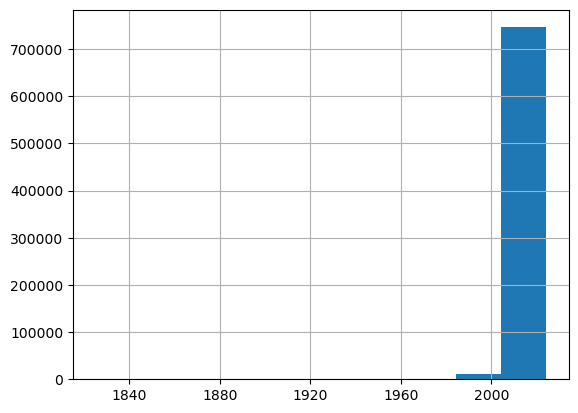

In [147]:
df['publish_time'] = pd.to_datetime(df['publish_time'])
df['publish_time'].hist()
plt.show()

## Yapılandırılmış Veri Çıkarımı

Özetlerden kolayca hangi tür bilgileri çıkarabileceğimize bir bakalım. İlgi çekebilecek bir konu, hangi tedavi stratejilerinin mevcut olduğunu ve zamanla nasıl evrildiklerini görmektir. Başlangıç olarak, COVID tedavisinde kullanılan olası ilaçların bir listesini ve ayrıca teşhislerin bir listesini manuel olarak derleyebiliriz. Daha sonra bunları gözden geçirip makalelerin özetlerinde karşılık gelen terimleri ararız.


In [148]:
medications = [
    'hydroxychloroquine', 'chloroquine', 'tocilizumab', 'remdesivir', 'azithromycin', 
    'lopinavir', 'ritonavir', 'dexamethasone', 'heparin', 'favipiravir', 'methylprednisolone']
diagnosis = [
    'covid','sars','pneumonia','infection','diabetes','coronavirus','death'
]

for m in medications:
    print(f" + Processing medication: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))
    
for m in diagnosis:
    print(f" + Processing diagnosis: {m}")
    df[m] = df['abstract'].apply(lambda x: str(x).lower().count(' '+m))

 + Processing medication: hydroxychloroquine
 + Processing medication: chloroquine
 + Processing medication: tocilizumab
 + Processing medication: remdesivir
 + Processing medication: azithromycin
 + Processing medication: lopinavir
 + Processing medication: ritonavir
 + Processing medication: dexamethasone
 + Processing medication: heparin
 + Processing medication: favipiravir
 + Processing medication: methylprednisolone
 + Processing diagnosis: covid
 + Processing diagnosis: sars
 + Processing diagnosis: pneumonia
 + Processing diagnosis: infection
 + Processing diagnosis: diabetes
 + Processing diagnosis: coronavirus
 + Processing diagnosis: death


Veri çerçevemize, bir özet içinde belirli bir ilacın/teşhisin kaç kez geçtiğini içeren bir dizi sütun ekledik.

> **Not**: Bir alt dize ararken kelimenin başına boşluk ekliyoruz. Bunu yapmazsak yanlış sonuçlar alabiliriz, çünkü *klorokin* kelimesi *hidroksiklorokin* alt dizesi içinde de bulunabilir. Ayrıca, özetler sütununu `str` tipine dönüştürmeye zorluyoruz, böylece bir hatadan kurtuluyoruz - `str` kısmını kaldırmayı deneyin ve ne olduğunu görün.

Verilerle çalışmayı kolaylaştırmak için, yalnızca ilaç sayımlarını içeren bir alt çerçeve çıkarabilir ve toplam geçiş sayısını hesaplayabiliriz. Bu, en popüler ilacı bulmamızı sağlar:


In [149]:
dfm = df[medications]
dfm = dfm.sum().reset_index().rename(columns={ 'index' : 'Name', 0 : 'Count'})
dfm.sort_values('Count',ascending=False)

Name  Count
0   hydroxychloroquine   9806
3           remdesivir   7861
2          tocilizumab   6118
1          chloroquine   4578
8              heparin   4161
5            lopinavir   3811
4         azithromycin   3585
7        dexamethasone   3340
9          favipiravir   2439
10  methylprednisolone   1600
6            ritonavir    948

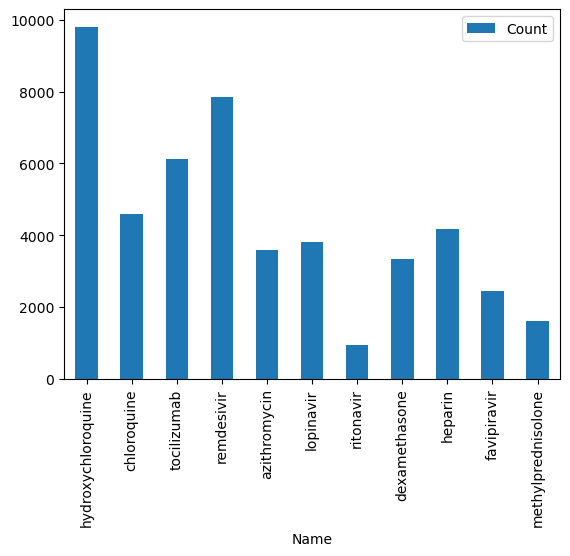

In [150]:
dfm.set_index('Name').plot(kind='bar')
plt.show()

## Tedavi Stratejisinde Eğilimleri Aramak

Yukarıdaki örnekte tüm değerleri `sum` ile topladık, ancak aynı işlemi aylık bazda da yapabiliriz:


In [151]:
dfm = df[['publish_time']+medications].set_index('publish_time')
dfm = dfm[(dfm.index>="2020-01-01") & (dfm.index<="2021-07-31")]
dfmt = dfm.groupby([dfm.index.year,dfm.index.month]).sum()
dfmt

hydroxychloroquine  chloroquine  tocilizumab  \
publish_time publish_time                                                 
2020         1                           3672         1773         1779   
             2                              0           19            0   
             3                             45           72            5   
             4                            188          238           50   
             5                            459          191          158   
             6                            381          149          243   
             7                            381          178          202   
             8                            307          115          172   
             9                            319          123          185   
             10                           319           96          212   
             11                           272           66          170   
             12                           255          102          229   
2021         1                           2191          780         1787   
             2                            163           66          184   
             3                            172           85          190   
             4                            198           70          125   
             5                            141           55          138   
             6                            144           29          138   
             7                            112           49           96   

                           remdesivir  azithromycin  lopinavir  ritonavir  \
publish_time publish_time                                                   
2020         1                   2134          1173       1430        370   
             2                      3             3         18         11   
             3                     27            12         52         16   
             4                    124            68        113         13   
             5                    209           132        135         41   
             6                    186           110        132         18   
             7                    165           108        138         29   
             8                    165           145         91         24   
             9                    190            91         98         28   
             10                   227            72        127         39   
             11                   197            79        104         27   
             12                   271            98         76         31   
2021         1                   2523           892        841        198   
             2                    173            85         76          9   
             3                    295            87        100         17   
             4                    161            83         60         13   
             5                    179            69         55         21   
             6                    182            75         41         12   
             7                    270            64         59          5   

                           dexamethasone  heparin  favipiravir  \
publish_time publish_time                                        
2020         1                       561      984          666   
             2                         1        3           12   
             3                         3       21           11   
             4                        14       77           48   
             5                        12       92           48   
             6                        48       84           30   
             7                        58      117           56   
             8                        56       95           45   
             9                        90      111           46   
             10                       97      117           81   
             11                       77 

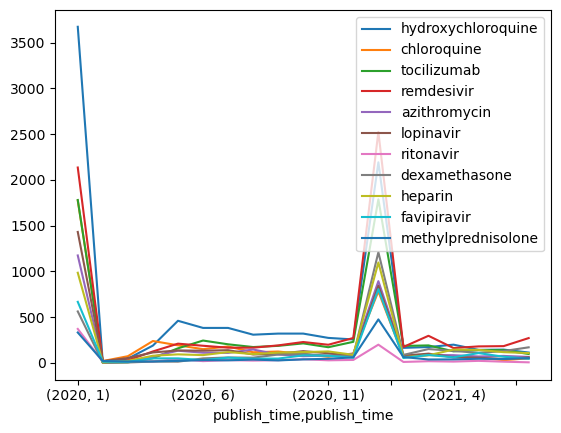

In [152]:
dfmt.plot()
plt.show()

İlginç bir gözlem, iki noktada büyük sıçramalar olduğudur: Ocak 2020 ve Ocak 2021. Bunun nedeni, bazı makalelerin yayınlanma tarihinin net bir şekilde belirtilmemesi ve ilgili yılın Ocak ayı olarak belirtilmesidir.

Veriyi daha anlamlı hale getirmek için, sadece birkaç ilacı görselleştirelim. Ayrıca Ocak ayına ait verileri "silip", yerine orta bir değer koyarak daha düzgün bir grafik elde edelim:


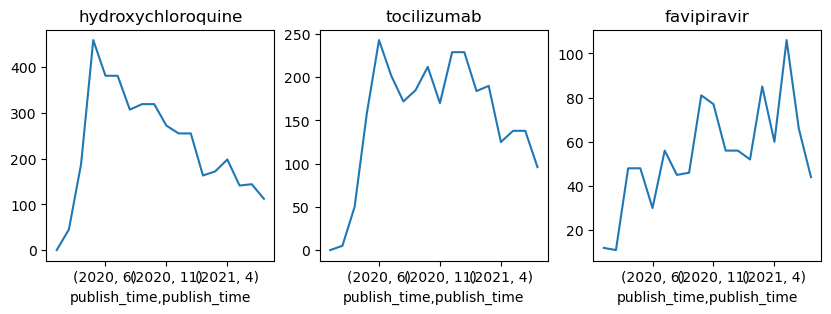

In [153]:
meds = ['hydroxychloroquine','tocilizumab','favipiravir']
dfmt.loc[(2020,1)] = np.nan
dfmt.loc[(2021,1)] = np.nan
dfmt.fillna(method='pad',inplace=True)
fig, ax = plt.subplots(1,len(meds),figsize=(10,3))
for i,m in enumerate(meds):
    dfmt[m].plot(ax=ax[i])
    ax[i].set_title(m)
plt.show()

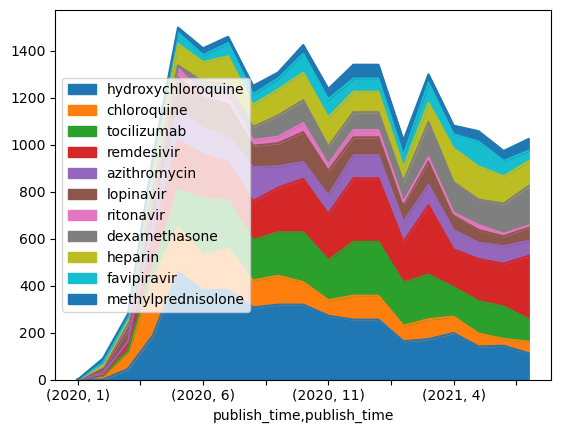

In [154]:
dfmt.plot.area()
plt.show()

Dahası, yüzde olarak göreceli popülerliği hesaplayabiliriz:


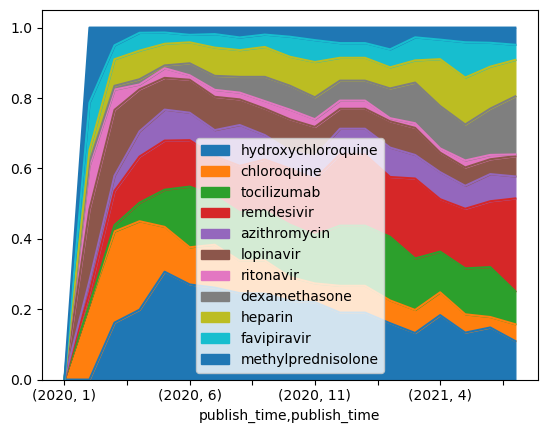

In [155]:
dfmtp = dfmt.iloc[:,:].apply(lambda x: x/x.sum(), axis=1)
dfmtp.plot.area()
plt.show()

## Tıp ve Teşhis Uyumu Hesaplama

İnceleyebileceğimiz en ilginç ilişkilerden biri, farklı teşhislerin farklı ilaçlarla nasıl tedavi edildiğidir. Bunu görselleştirebilmek için, iki terimin aynı makalede kaç kez geçtiğini gösteren bir **eş-zamanlılık sıklık haritası** hesaplamamız gerekiyor.

Bu tür bir harita, esasen **numpy array** ile en iyi şekilde temsil edilen 2D bir matristir. Bu haritayı hesaplamak için tüm özetleri inceleyerek, orada geçen varlıkları işaretleyeceğiz:


In [156]:
m = np.zeros((len(medications),len(diagnosis)))
for a in df['abstract']:
    x = str(a).lower()
    for i,d in enumerate(diagnosis):
        if ' '+d in x:
            for j,me in enumerate(medications):
                if ' '+me in x:
                    m[j,i] += 1

In [157]:
m

array([[4788., 2264.,  741., 2109.,  348., 2730.,  975.],
       [2111., 1238.,  231.,  998.,   79., 1394.,  364.],
       [2186.,  821.,  691., 1063.,  185., 1136.,  573.],
       [3210., 2191.,  522., 1538.,  160., 2191.,  622.],
       [1803.,  773.,  406.,  880.,  133.,  909.,  410.],
       [1982., 1102.,  379.,  885.,  113., 1366.,  370.],
       [ 504.,  356.,   83.,  259.,   23.,  354.,  106.],
       [1419.,  640.,  345.,  742.,  108.,  760.,  314.],
       [1537.,  678.,  330.,  782.,   93.,  826.,  301.],
       [ 967.,  634.,  201.,  431.,   44.,  656.,  136.],
       [ 660.,  336.,  293.,  385.,   53.,  452.,  148.]])

Bu matrisi görselleştirmenin yollarından biri bir **ısı haritası** çizmektir:


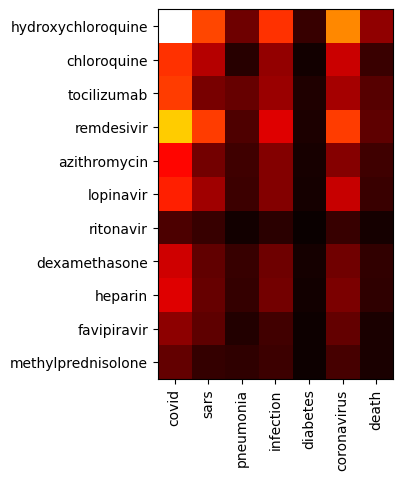

In [158]:
plt.imshow(m,interpolation='nearest',cmap='hot')
ax = plt.gca()
ax.set_yticks(range(len(medications))) 
ax.set_yticklabels(medications)
ax.set_xticks(range(len(diagnosis)))
ax.set_xticklabels(diagnosis,rotation=90)
plt.show()

Ancak, **Sankey** diyagramı kullanılarak çok daha iyi bir görselleştirme yapılabilir! `matplotlib` bu diyagram türü için yerleşik bir destek sunmaz, bu yüzden [Plotly](https://plotly.com/python/) kullanmamız gerekecek. Bunun nasıl yapılacağını [bu öğreticide](https://plotly.com/python/sankey-diagram/) bulabilirsiniz.

Plotly ile bir Sankey diyagramı oluşturmak için şu listeleri oluşturmamız gerekiyor:
* Grafikteki tüm düğümleri içeren `all_nodes` listesi. Bu liste hem ilaçları hem de teşhisleri içerecek.
* Kaynak ve hedef indekslerinin listesi - bu listeler, hangi düğümlerin diyagramın sol tarafına, hangilerinin sağ tarafına gittiğini gösterecek.
* Tüm bağlantıların listesi. Her bağlantı şu bileşenlerden oluşur:
   - `all_nodes` dizisindeki kaynak indeksi
   - Hedef indeksi
   - Bağlantının gücünü gösteren bir değer. Bu, tam olarak eş-oluşum matrisimizden alınan değerdir.
   - İsteğe bağlı olarak bağlantının rengi. Bazı terimleri netleştirmek için vurgulama seçeneği sunacağız.

Sankey diyagramı çizmek için genel kod, iki listeyi (kaynak ve hedef kategorileri) ve eş-oluşum matrisini alan ayrı bir `sankey` fonksiyonu olarak yapılandırılmıştır. Ayrıca bir eşik değeri belirlememize ve bu eşikten daha zayıf olan tüm bağlantıları atlamamıza olanak tanır - bu, diyagramı biraz daha az karmaşık hale getirir.


In [160]:
import plotly.graph_objects as go

def sankey(cat1, cat2, m, treshold=0, h1=[], h2=[]):
    all_nodes = cat1 + cat2
    source_indices = list(range(len(cat1)))
    target_indices = list(range(len(cat1),len(cat1)+len(cat2)))

    s, t, v, c = [], [], [], []
    for i in range(len(cat1)):
        for j in range(len(cat2)):
            if m[i,j]>treshold:
                s.append(i)
                t.append(len(cat1)+j)
                v.append(m[i,j])
                c.append('pink' if i in h1 or j in h2 else 'lightgray')

    fig = go.Figure(data=[go.Sankey(
        # Define nodes
        node = dict(
        pad = 40,
        thickness = 40,
        line = dict(color = "black", width = 1.0),
        label =  all_nodes),

        # Add links
        link = dict(
        source =  s,
        target =  t,
        value =  v,
        color = c
    ))])
    fig.show()

sankey(medications,diagnosis,m,500,h2=[0])

## Sonuç

Metin gibi yapılandırılmamış veri kaynaklarından bilgi çıkarmak için oldukça basit yöntemler kullanabileceğimizi gördünüz. Bu örnekte mevcut ilaç listesini kullandık, ancak metinden varlık çıkarımı yapmak için doğal dil işleme (NLP) tekniklerini kullanmak çok daha güçlü olurdu. [Bu blog yazısında](https://soshnikov.com/science/analyzing-medical-papers-with-azure-and-text-analytics-for-health/) varlık çıkarımı için bulut hizmetlerini nasıl kullanabileceğimizi anlatıyoruz. Bir diğer seçenek ise [NLTK](https://www.nltk.org/) gibi Python NLP kütüphanelerini kullanmak olabilir - NLTK kullanarak metinden bilgi çıkarma yaklaşımı [burada](https://www.nltk.org/book/ch07.html) açıklanmıştır.


## Zorluk

COVID makale verilerini aşağıdaki doğrultuda araştırmaya devam edin:

1. Farklı ilaçların eş-oluşum matrisini oluşturun ve hangi ilaçların sıklıkla birlikte geçtiğini (örneğin, bir özet içinde bahsedildiğini) görün. İlaçlar ve teşhisler için eş-oluşum matrisi oluşturma kodunu değiştirebilirsiniz.
1. Bu matrisi bir ısı haritası kullanarak görselleştirin.
1. Ekstra bir hedef olarak, ilaçların eş-oluşumunu [chord diagram](https://en.wikipedia.org/wiki/Chord_diagram) kullanarak görselleştirmeyi deneyebilirsiniz. [Bu kütüphane](https://pypi.org/project/chord/) bir chord diagram çizmenize yardımcı olabilir.
1. Başka bir ekstra hedef olarak, farklı ilaçların dozajlarını (örneğin, *günde 400mg klorokin alın* ifadesindeki **400mg** gibi) düzenli ifadeler kullanarak çıkarmayı deneyin ve farklı ilaçlar için farklı dozajları gösteren bir dataframe oluşturun. **Not**: İlaç isminin yakın metinsel çevresindeki sayısal değerlere dikkat edin.



---

**Feragatname**:  
Bu belge, AI çeviri hizmeti [Co-op Translator](https://github.com/Azure/co-op-translator) kullanılarak çevrilmiştir. Doğruluk için çaba göstersek de, otomatik çevirilerin hata veya yanlışlıklar içerebileceğini lütfen unutmayın. Belgenin orijinal dili, yetkili kaynak olarak kabul edilmelidir. Kritik bilgiler için profesyonel bir insan çevirisi önerilir. Bu çevirinin kullanımından kaynaklanan yanlış anlamalar veya yanlış yorumlamalardan sorumlu değiliz.
